Basket testing with layer1 coins, trading on btc

In [9]:
from dotenv import load_dotenv
from binance.client import Client as bnb_client
import os

load_dotenv()
# need TLD in US if US
client = bnb_client(tld='US', api_key=os.getenv('BINANCE_API'), api_secret=os.getenv('BINANCE_SECRET'))

In [10]:
all_binance_symbols =[symbol['symbol'] for symbol in client.get_exchange_info()['symbols']]
print(len(all_binance_symbols))

all_usdt_pairs = [symbol['symbol']  for symbol in client.get_exchange_info()['symbols'] if symbol['quoteAsset'] == 'USDT']
len(all_usdt_pairs)

552


179

In [129]:

import datetime
import pandas as pd 
import numpy as np 

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    data['close_time'] = data['close_time'].map(lambda x: datetime.datetime.fromtimestamp(x/1000, datetime.timezone.utc))
    return data 

univ = all_binance_symbols

freq = '1h'
filename = 'binance_{freq}_px.pkl'.format(freq=freq)
if filename not in os.listdir():
    px = {}
    for x in univ:
        data = get_binance_px(x,freq)
        px[x] = data.set_index('open_time')['close']

    px = pd.DataFrame(px).astype(float)
    px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
    px.to_pickle(filename)
else:
    px = pd.read_pickle(filename)
ret = px.pct_change()
out_of_sample_ret = ret['2023-12-01':]
ret = ret[:'2023-12-01']

C:\Users\joshu\AppData\Local\Temp\ipykernel_10608\285250023.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ret = px.pct_change()


In [130]:
import requests

def get_layer1_coin_names():
    # Step 1: Define the API endpoint and parameters
    api_url = f'https://api.coingecko.com/api/v3/coins/markets'
    category = 'smart-contract-platform'  # Adjust based on actual category
    per_page = 250
    page = 1
    vs_currency = 'usd'
    order = 'market_cap_desc'
    sparkline = 'false'

    coin_names = []
    coin_ticker = []

    while True:
        params = {
            'vs_currency': vs_currency,
            'category': category,
            'order': order,
            'per_page': per_page,
            'page': page,
            'sparkline': sparkline
        }

        response = requests.get(api_url, params=params)

        if response.status_code != 200:
            print(f"Error: Unable to fetch data (Status Code: {response.status_code})")
            break

        data = response.json()

        if not data:
            # No more data to fetch
            break
        
        # Extract coin names
        for coin in data:
            coin_names.append(coin['name'])
            coin_ticker.append(coin['symbol'])

        print(f"Fetched page {page} with {len(data)} coins.")

        page += 1
    return coin_ticker

layer1_coins = get_layer1_coin_names()
print(f"\nTotal Layer 1 Coins Found: {len(layer1_coins)}")


Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 239 coins.

Total Layer 1 Coins Found: 739


In [131]:
exchange_info = client.get_exchange_info()
binance_base_assets = [x['baseAsset'] for x in exchange_info['symbols']]

In [132]:
layer1_coin = [x.upper() for x in layer1_coins]
layer1_coin = [x for x in layer1_coin if x in binance_base_assets]
len(layer1_coin)

84

In [133]:
binance_layer1_symbols = [x['symbol'] for x in exchange_info['symbols'] if (x['baseAsset'] in layer1_coin and x['quoteAsset'] == 'USDT')]
binance_layer1_symbols = [x for x in binance_layer1_symbols if x in ret.columns]
layer1_binance_ret = ret[binance_layer1_symbols]
out_of_sample_layer1_binance_ret = out_of_sample_ret[binance_layer1_symbols]

In [134]:
def compute_to_sharpe(weightings, ret, th = 1, to_off = False):
    to = weightings.diff().abs().sum(1)
    port_ret = (weightings.shift(th) * ret).sum(1)
    bps = .0020
    if to_off:
        bps = 0
    port_ret = port_ret - bps * to
    print("Average Turnover: ", to.mean())
    print("Sharpe Ratio: ", np.sqrt(24*365) * port_ret.mean() / port_ret.std())
    port_ret.cumsum().plot()

def to_sharpe(weightings, ret, th = 1, to_off = False, plot = False, return_ret = False):
        weightings = weightings.iloc[::th].fillna(0)
        ret_prod = (1+ret).cumprod()
        ret = ret_prod.divide(ret_prod.shift(th), axis = 0) - 1
        ret = ret[::th].fillna(0)
        to = weightings.diff().abs().sum(1)
        port_ret = (weightings.shift(1) * ret).sum(1)
        bps = .0020
        if to_off:
            bps = 0
        port_ret = port_ret - bps * to
        if return_ret:
            return port_ret,to, ret, weightings
        avg_to = to.mean()
        sharpe = np.sqrt(24*365/th) * port_ret.mean() / port_ret.std()
        drawdown = port_ret.cumsum().cummax() - port_ret.cumsum()
        max_drawdown = drawdown.max()
        drawdown_durations = (drawdown > 0).cumsum()
        durations = drawdown_durations.groupby(drawdown_durations).cumcount()
        max_drawdown_duration = durations.max()*th/24
        if plot:
            print("Corr with BTC: ", port_ret.corr(ret['BTCUSDT']))
            print("Average Turnover: ", avg_to)
            print("Sharpe Ratio: ", sharpe)
            port_ret.cumsum().plot()
        return avg_to, sharpe, max_drawdown, max_drawdown_duration


    

In [135]:
btc_ret = ret['BTCUSDT']


Signal

Each hour, buy losing coins within the industry, and sell a basket of the most correlated in industry above 0.3 with equal weighting
or do the opposite

PARAMETERS:
 - number of coins to buy/sell without basket
 - buy winner or loser?
 - basket weighitngs/choosing parameters (what stocks, weightings of basket portfolio)
 - time horizon
 - when to trade

RESULTS:
- BASIC REVERSAL Buying/selling loser/winner in 1h time horizon: to - 0.5, sharpe: -3
- best basic reversal rank weightng: to - 0.83, sharpe - 0.449491(drawdown duration is almost a year and drawdown ~50%)
    - did grid search
- best rank threshold weighting MOMENTUM
    - threshold = 0.8, best sharpe is 0.41, but performance for last 3 years is very good, worse in 2021-2022, avg_to = 1.49
    - threshold = 0.6, best sharpe is 0.01, but graph looks similar to above, but performance in 2021 is much worse
- best rank threshold weighting MOMENTUM
    - threshold = 0.8, best sharpe is 0.41, but performance for last 3 years is very good, worse in 2021-2022, avg_to = 1.49
    - threshold = 0.6, best sharpe is 0.01, but graph looks similar to above, but performance in 2021 is much worse
- Buy loser sell 10 coins equal weighted that are most correlated with loser: to - 1.1, sharpe = -17 (basketn = 10, lookback = 24)
    - basketn = 5, lookback = 48: to - 1.3, sharpe = -17
    - basketn = 5, lookback = 72: to - 1.3, sharpe = -17
- channel breakout long short 2.0 sharpe in sample and 3.0 out of sample. long basket is very correlated with btc but short isnt
momentum in gridsearch lokoback/th doesnt work


In [136]:
def equal_weighting(ret):
    '''equal weighting of returns'''
    return ret.div(ret.abs().sum(axis=1),axis=0)

def rank_weighting(ret, lookback= 1):
    '''rank weighting of returns in the lookback period'''
    ranked_ret = ret.rank(axis=1, pct=True).rolling(lookback).mean()
    ranked_ret = ranked_ret.subtract(ranked_ret.mean(axis=1),axis=0)
    return ranked_ret.div(ranked_ret.abs().sum(axis=1),axis=0)

def rank_threshold_weighting(df, lookback = 1, threshold = 0.51):
    '''rank weighting with threshold'''
    df = df.rank(axis=1, pct=True)-0.5
    df = df.rolling(lookback).mean()
    if threshold < 0.5:
        threshold = 1 - threshold
    arr = df.to_numpy()
    low_q = np.full((arr.shape[0], 1), np.nan)
    high_q = np.full((arr.shape[0], 1), np.nan)
    non_nan_mask = ~np.all(np.isnan(arr), axis=1)
    low_q[non_nan_mask] = np.nanquantile(arr[non_nan_mask], threshold, axis=1, keepdims=True)
    high_q[non_nan_mask] = np.nanquantile(arr[non_nan_mask], 1 - threshold, axis=1, keepdims=True)
    mask = (arr >= low_q) | (arr <= high_q)
    out = np.where(mask, arr, 0)
    out = out-out.mean(axis=1, keepdims=True)
    row_sums = np.abs(out).sum(axis=1, keepdims=True)
    row_sums[row_sums == 0] = np.nan  # Avoid division by zero by replacing with NaN
    out = out / row_sums
    return -pd.DataFrame(out, index = df.index, columns = df.columns).fillna(0)

def reversal_weightings(ret):
    '''portfolio weightings based on signal weightings for reversal strategy'''
    # set max to -0.5 and min to 0.5
    def transform_row(row):
        max_val = row.max()
        min_val = row.min()
        return row.map(lambda x: -0.5 if x == max_val else (0.5 if x == min_val else 0))

    def long_short_basket(ret, lookback = 72, number_stock_basket = 10, buyorsell = 'buy'):
        '''long short basket of stocks based on correlation'''
        f = lambda x: x.idxmin()
        multiplier = 1
        if buyorsell == 'sell':
            f = lambda x: x.idxmax()
            multiplier = -1
        buysell_coin = ret.apply(f, axis = 1).dropna()
        
        rolling_corrs = ret.rolling(lookback)
        rolling_corrs = rolling_corrs.apply(lambda x: x.corr(x[buysell_coin[x.name]]))

        print(rolling_corrs)

    ret = long_short_basket(ret)
    return ret.apply(lambda x: x / x.abs().sum(), axis=1)


signal = rank_threshold_weighting(layer1_binance_ret, lookback = 10)

In [137]:
def long_channel_breakout_signal(ret, short_lookback=1, enter_lookback=24*25, exit_lookback=24*5):
    """
    Generate channel breakout signals for multiple assets.

    Parameters:
      ret : pandas.DataFrame
          DataFrame of asset returns (or prices) with a DateTime index and assets as columns.
      short_lookback : int, optional
          Lookback period for short-term high/low calculations.
      enter_lookback : int, optional
          Lookback period for the entry threshold (long-term high).
      exit_lookback : int, optional
          Lookback period for the exit threshold (long-term low).

    Returns:
      signals_df : pandas.DataFrame
          A DataFrame with MultiIndex columns:
            - First level: 'ret', 'enter_signal', 'exit_signal', 'action'
            - Second level: asset names.
          The 'action' column is 'enter' when enter_signal > 0 and 'exit' when exit_signal < 0.
    """
    # Compute rolling values for each asset.
    # Note: We set min_periods=1 to get output from the very start; 
    # if you require full windows to start generating signals, you can set min_periods=window_size.
    short_max      = ret.rolling(window=short_lookback, min_periods=1).max()
    short_min      = ret.rolling(window=short_lookback, min_periods=1).min()
    long_enter_max = ret.rolling(window=enter_lookback, min_periods=1).max()
    long_exit_min  = ret.rolling(window=exit_lookback, min_periods=1).min()
    
    # Compute signals (fully vectorized across all assets)
    enter_signal = short_max - long_enter_max
    exit_signal  = short_min - long_exit_min
    
    # Create the 'action' signal:
    #   - 'enter' when enter_signal > 0
    #   - 'exit' when exit_signal < 0 (only if no enter signal)
    # The np.where calls are fully vectorized.
    position = pd.DataFrame(
        np.where(enter_signal == 0, 1, np.where(exit_signal == 0, 0, np.nan)),
        index=ret.index,
        columns=ret.columns
    )
    position = position.ffill().fillna(0)
    
    # Combine everything into one DataFrame with MultiIndex columns.
    return position

signal = equal_weighting(long_channel_breakout_signal(layer1_binance_ret))
    

In [138]:
def short_channel_breakout_signal(ret, short_lookback=1, enter_lookback=24*25, exit_lookback=24*5):
    """
    Generate channel breakout signals for multiple assets.

    Parameters:
      ret : pandas.DataFrame
          DataFrame of asset returns (or prices) with a DateTime index and assets as columns.
      short_lookback : int, optional
          Lookback period for short-term high/low calculations.
      enter_lookback : int, optional
          Lookback period for the entry threshold (long-term high).
      exit_lookback : int, optional
          Lookback period for the exit threshold (long-term low).

    Returns:
      signals_df : pandas.DataFrame
          A DataFrame with MultiIndex columns:
            - First level: 'ret', 'enter_signal', 'exit_signal', 'action'
            - Second level: asset names.
          The 'action' column is 'enter' when enter_signal > 0 and 'exit' when exit_signal < 0.
    """
    # Compute rolling values for each asset.
    # Note: We set min_periods=1 to get output from the very start; 
    # if you require full windows to start generating signals, you can set min_periods=window_size.
    short_max      = ret.rolling(window=short_lookback, min_periods=1).max()
    short_min      = ret.rolling(window=short_lookback, min_periods=1).min()
    long_enter_min= ret.rolling(window=enter_lookback, min_periods=1).max()
    long_exit_max  = ret.rolling(window=exit_lookback, min_periods=1).min()
    
    # Compute signals (fully vectorized across all assets)
    enter_signal = short_min - long_enter_min
    exit_signal  = short_max - long_exit_max
    
    # Create the 'action' signal:
    #   - 'enter' when enter_signal > 0
    #   - 'exit' when exit_signal < 0 (only if no enter signal)
    # The np.where calls are fully vectorized.
    position = pd.DataFrame(
        np.where(enter_signal == 0, -1, np.where(exit_signal == 0, 0, np.nan)),
        index=ret.index,
        columns=ret.columns
    )
    position = position.ffill().fillna(0)
    
    # Combine everything into one DataFrame with MultiIndex columns.
    return position

signal = equal_weighting(short_channel_breakout_signal(layer1_binance_ret))
    

In [139]:
def grid_search_channel_breakout(ret, short_lookback=1, enter_lookback_list=None, exit_lookback_list=None, th=1, to_off=False):
    """
    Perform a grid search over channel breakout parameters (entry and exit lookback) and evaluate performance.
    
    Parameters:
      ret : pandas.DataFrame
          DataFrame of asset prices (or returns) with a DateTime index and assets as columns.
      short_lookback : int, optional
          Fixed short-term lookback period used in the channel breakout calculation.
      enter_lookback_list : list, optional
          List of entry lookback parameters to test.
      exit_lookback_list : list, optional
          List of exit lookback parameters to test.
      th : int, optional
          Thinning parameter for the performance calculation.
      to_off : bool, optional
          If True, turnover costs are turned off.
          
    Returns:
      results_df : pandas.DataFrame
          A DataFrame summarizing the performance metrics for each combination of parameters.
    """
    if enter_lookback_list is None:
        enter_lookback_list = [2, 4, 8, 12, 24, 24 * 2, 24 * 3, 24 * 4, 24 * 7, 24 * 14, 24 * 21]
    if exit_lookback_list is None:
        exit_lookback_list = [24 * 3, 24 * 4, 24 * 7, 24 * 14, 24 * 21, 24 * 28,  24 * 35, 24 * 42, 24 * 49, 24 * 56]
    
    results = []
    for enter_lb in enter_lookback_list:
        for exit_lb in exit_lookback_list:
            # Compute channel breakout signals (which include a binary 'position')
            signals_df = long_channel_breakout_signal(
                ret,
                short_lookback=short_lookback,
                enter_lookback=enter_lb,
                exit_lookback=exit_lb
            )
            
            # Extract the binary position signal.
            # Note: signals_df has MultiIndex columns; we take the 'position' level.
            positions = signals_df
            
            # Convert binary positions to equal weightings (equal allocation among assets that are "in")
            weightings = equal_weighting(positions)
            
            # Evaluate performance using the provided to_sharpe function.
            avg_to, sharpe, max_drawdown, max_drawdown_duration = to_sharpe(weightings, ret, th=th, to_off=to_off, plot=False)
            
            # Store the results.
            results.append({
                'short_lookback': short_lookback,
                'enter_lookback': enter_lb,
                'exit_lookback': exit_lb,
                'avg_turnover': avg_to,
                'sharpe': sharpe,
                'max_drawdown': max_drawdown,
                'max_drawdown_duration': max_drawdown_duration
            })
    
    results_df = pd.DataFrame(results)
    return results_df

grid_channel = grid_search_channel_breakout(layer1_binance_ret, th=1, to_off=False)

In [140]:
grid_channel.sort_values('sharpe', ascending=False).head(10)

,short_lookback,enter_lookback,exit_lookback,avg_turnover,sharpe,max_drawdown,max_drawdown_duration
9,1,2,1344,0.005218,1.189165,1.613661,0.416667
8,1,2,1176,0.005702,1.154876,1.631390,0.416667
19,1,4,1344,0.005355,1.141623,1.659140,0.416667
7,1,2,1008,0.006346,1.132395,1.639710,0.416667
18,1,4,1176,0.005882,1.105022,1.681469,0.416667
6,1,2,840,0.006993,1.104418,1.660903,0.416667
5,1,2,672,0.008299,1.095927,1.709145,0.416667
29,1,8,1344,0.005363,1.077188,1.685778,0.416667
17,1,4,1008,0.006579,1.076869,1.700882,0.416667
16,1,4,840,0.007270,1.046029,1.727182,0.416667


<Axes: xlabel='exit_lookback', ylabel='enter_lookback'>

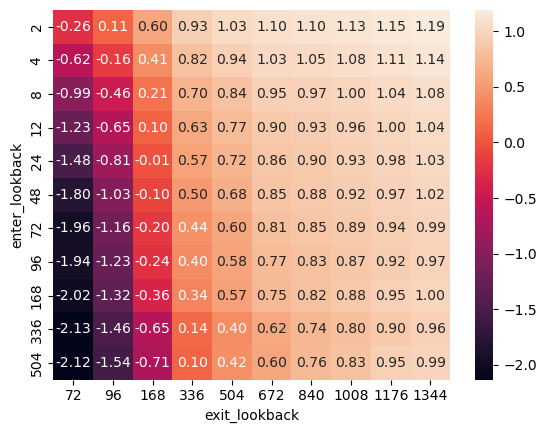

In [141]:
import seaborn as sns

sns.heatmap(grid_channel.pivot_table(index='enter_lookback', columns='exit_lookback', values='sharpe'), annot=True, fmt=".2f")

<Axes: xlabel='exit_lookback', ylabel='enter_lookback'>

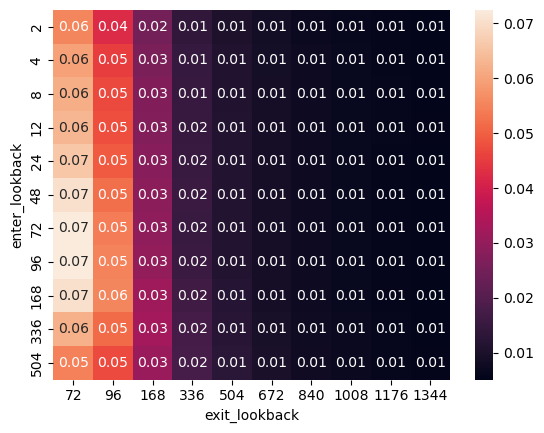

In [157]:
sns.heatmap(grid_channel.pivot_table(index='enter_lookback', columns='exit_lookback', values='avg_turnover'), annot=True, fmt=".2f")

Corr with BTC:  0.7950451603750606
Average Turnover:  0.008794661002861762
Sharpe Ratio:  0.9456206566068234


(0.008794661002861762,
 0.9456206566068234,
 1.8409254645890125,
 0.4166666666666667)

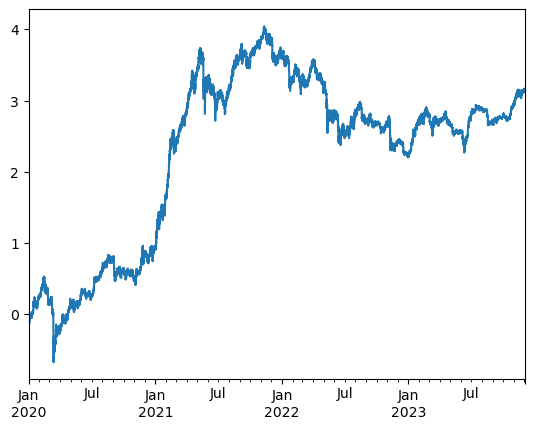

In [160]:
signal = equal_weighting(long_channel_breakout_signal(layer1_binance_ret,   short_lookback=1, enter_lookback=8, exit_lookback=24*28))

to_sharpe(signal, ret, th = 1, to_off = False, plot = True)

In [150]:
def short_grid_search_channel_breakout(ret, short_lookback=1, enter_lookback_list=None, exit_lookback_list=None, th=1, to_off=False):
    """
    Perform a grid search over channel breakout parameters (entry and exit lookback) and evaluate performance.
    
    Parameters:
      ret : pandas.DataFrame
          DataFrame of asset prices (or returns) with a DateTime index and assets as columns.
      short_lookback : int, optional
          Fixed short-term lookback period used in the channel breakout calculation.
      enter_lookback_list : list, optional
          List of entry lookback parameters to test.
      exit_lookback_list : list, optional
          List of exit lookback parameters to test.
      th : int, optional
          Thinning parameter for the performance calculation.
      to_off : bool, optional
          If True, turnover costs are turned off.
          
    Returns:
      results_df : pandas.DataFrame
          A DataFrame summarizing the performance metrics for each combination of parameters.
    """
    if enter_lookback_list is None:
        enter_lookback_list = [8, 12, 24, 24 * 2, 24 * 3, 24 * 4, 24 * 7, 24 * 14, 24 * 21, 24 * 28, 24 * 35, 24 * 42, 24 * 49, 24 * 56]
    if exit_lookback_list is None:
        exit_lookback_list = [4, 8, 12, 24, 24 * 2, 24 * 3, 24 * 4, 24 * 7, 24 * 14, 24 * 21, 24 * 28]
    
    results = []
    for enter_lb in enter_lookback_list:
        for exit_lb in exit_lookback_list:
            # Compute channel breakout signals (which include a binary 'position')
            signals_df = short_channel_breakout_signal(
                ret,
                short_lookback=short_lookback,
                enter_lookback=enter_lb,
                exit_lookback=exit_lb
            )
            
            # Extract the binary position signal.
            # Note: signals_df has MultiIndex columns; we take the 'position' level.
            positions = signals_df
            
            # Convert binary positions to equal weightings (equal allocation among assets that are "in")
            weightings = equal_weighting(positions)
            
            # Evaluate performance using the provided to_sharpe function.
            avg_to, sharpe, max_drawdown, max_drawdown_duration = to_sharpe(weightings, ret, th=th, to_off=to_off, plot=False)
            
            # Store the results.
            results.append({
                'short_lookback': short_lookback,
                'enter_lookback': enter_lb,
                'exit_lookback': exit_lb,
                'avg_turnover': avg_to,
                'sharpe': sharpe,
                'max_drawdown': max_drawdown,
                'max_drawdown_duration': max_drawdown_duration
            })
    
    results_df = pd.DataFrame(results)
    return results_df

short_grid_channel = short_grid_search_channel_breakout(layer1_binance_ret, th=1, to_off=False)

In [151]:
short_grid_channel[short_grid_channel['avg_turnover'] > 0.01].sort_values('sharpe', ascending=False).head(10)

,short_lookback,enter_lookback,exit_lookback,avg_turnover,sharpe,max_drawdown,max_drawdown_duration
133,1,1176,8,0.060325,2.258581,0.787773,8.666667
144,1,1344,8,0.056158,2.139132,1.107251,16.458333
134,1,1176,12,0.058079,2.018814,0.558644,7.750000
122,1,1008,8,0.065630,2.018109,1.159738,13.041667
145,1,1344,12,0.053944,1.961006,0.767055,7.750000
111,1,840,8,0.073063,1.922681,1.160390,24.000000
132,1,1176,4,0.062824,1.861821,1.127173,10.166667
143,1,1344,4,0.058810,1.795359,1.259182,16.458333
123,1,1008,12,0.063129,1.794075,0.723687,8.666667
100,1,672,8,0.085286,1.732285,1.138332,13.041667


<Axes: xlabel='exit_lookback', ylabel='enter_lookback'>

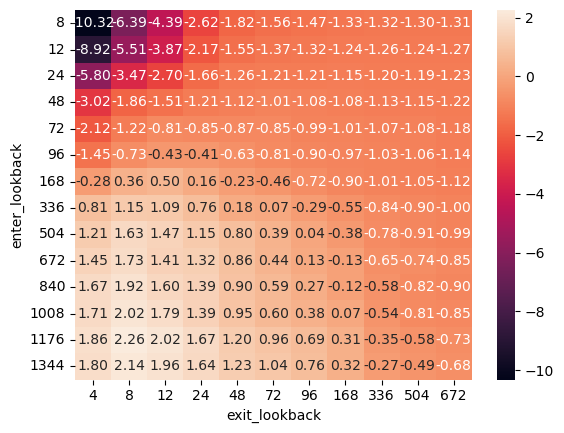

In [152]:
sns.heatmap(short_grid_channel.pivot_table(index='enter_lookback', columns='exit_lookback', values='sharpe'), annot=True, fmt=".2f")

Corr with BTC:  -0.1476273099771715
Average Turnover:  0.05807892817653557
Sharpe Ratio:  2.0188142093936663


(0.05807892817653557, 2.0188142093936663, 0.5586438364135635, 7.75)

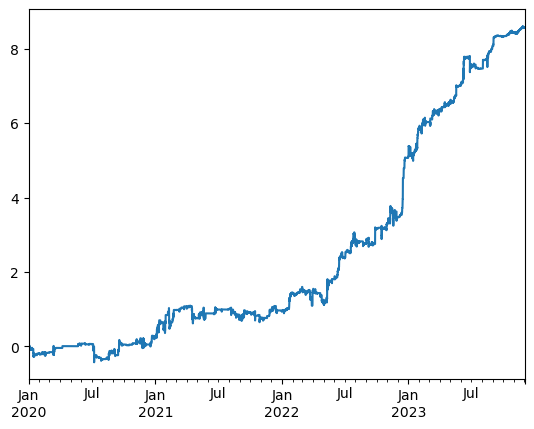

In [156]:
signal = equal_weighting(short_channel_breakout_signal(layer1_binance_ret,   short_lookback=1, enter_lookback=1176, exit_lookback=12))
to_sharpe(signal, ret, th = 1, to_off = False, plot = True)

Corr with BTC:  0.5269042712127442
Average Turnover:  0.034405259468815806
Sharpe Ratio:  3.266333125955329


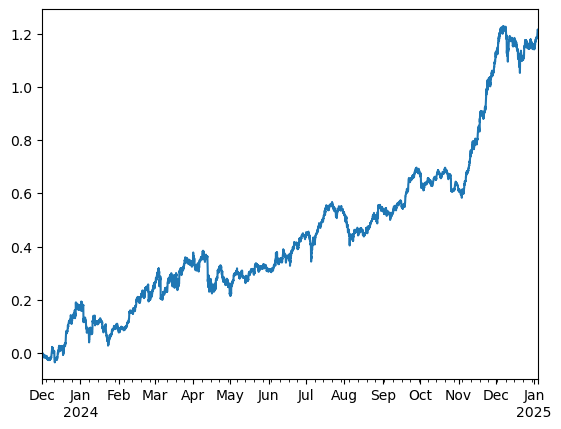

In [165]:
def long_short_channel_breakout(ret):
# combine long short channel breakout
    long_signal = equal_weighting(long_channel_breakout_signal(ret,   short_lookback=1, enter_lookback=8, exit_lookback=24*28))
    short_signal = equal_weighting(short_channel_breakout_signal(ret,   short_lookback=1, enter_lookback=1176, exit_lookback=12))
    long_short_signal = long_signal + short_signal
    long_short_signal = equal_weighting(long_short_signal)
    to_sharpe(long_short_signal, ret, th = 1, to_off = False, plot = True)
long_short_channel_breakout(out_of_sample_layer1_binance_ret)


In [11]:
from numba import njit

def long_short_basket(ret, lookback = 24, number_stock_basket = 10, buyorsell = 'buy'):
    '''long short basket of stocks based on correlation'''
    multiplier = 1
    if buyorsell == 'buy':
        buysell_coin = ret.idxmin(axis=1)
    elif buyorsell == 'sell':
        buysell_coin = ret.idxmax(axis=1)
        multiplier = -1
    rolling_corrs = pd.DataFrame(index=ret.index, columns=ret.columns)
    rolling_ret = ret.rolling(window=lookback)

    @njit
    def compute_corr(window1, window2):
        # Remove NaNs
        mask = (~np.isnan(window1)) & (~np.isnan(window2))
        valid_window1 = window1[mask]
        valid_window2 = window2[mask]
        
        if len(valid_window1) < 2:
            return np.nan
        # Compute correlation
        mean1 = valid_window1.mean()
        mean2 = valid_window2.mean()
        std1 = valid_window1.std()
        std2 = valid_window2.std()
        if std1 == 0 or std2 == 0:
            return np.nan
        covariance = ((valid_window1 - mean1) * (valid_window2 - mean2)).sum()
        correlation = covariance / (len(valid_window1) * std1 * std2)
        return correlation
    
    # Step 4: Iterate Over Each Column and Compute Rolling Correlations
    for col in ret.columns:
        col_data = ret[col].values
        corr_values = np.full(len(ret), np.nan)
        
        for i in range(lookback - 1, len(ret)):
            current_time = ret.index[i]
            coin = buysell_coin.get(current_time, np.nan)
            if pd.isna(coin):
                continue
            coin_series = ret[coin].values
            # Define window indices
            window_start = i - lookback + 1
            window_end = i + 1
            window1 = col_data[window_start:window_end]
            window2 = coin_series[window_start:window_end]
            # Compute correlation
            corr = compute_corr(window1, window2)
            corr_values[i] = corr
        
        rolling_corrs[col] = corr_values
    
    def set_weights(row):
        coin = buysell_coin.loc[row.name]
        largest_indices = np.argpartition(-row.values, number_stock_basket+1)[:number_stock_basket + 1]
        mask = np.zeros(len(row), dtype=bool)
        mask[largest_indices] = True
        row[~mask] = 0
        row[mask] = -multiplier/2/number_stock_basket
        row[coin] = multiplier/2
        
        return row
    weights = rolling_corrs.apply(set_weights, axis=1)
    # def get_corr(x):
    #     coin = buysell_coin.loc[x.index[-1]]
    #     return x.corr(ret.loc[:,coin])
    # for col in ret.columns:
    #     rolling_corrs.loc[:,col] = rolling_corrs[col].rolling(lookback).apply(get_corr)
    return weights, rolling_corrs
# temp = long_short_basket(layer1_binance_ret, lookback=72, number_stock_basket=5, buyorsell='sell')

In [ ]:
#grid search

def gridsearch(weightings, ret, **kwargs):
    """"
    Lookback is signal speed (e.g 12 means average signal from last 12 hours)
    th is holding period (e.g 8 means rebalance every 8 hours)
    """

    lookback = [1, 12, 24, 48, 96, 168, 336, 672]
    th = [1, 2, 3, 6, 18, 36, 72, 144, 168, 336]
    info = []
    
    for i in lookback:
        for j in th:
            weightings = weightings.rolling(i).mean(i)
            avg_to, sharpe, drawdown, drawdown_duration = to_sharpe(weightings, ret, th = j)
            info.append((i, j, avg_to, sharpe, drawdown, drawdown_duration, kwargs['lookback']))
    return info
# lookback =  [1, 2, 4, 8, 16, 24, 48,96, 168, 336]
# results = []
# for i in lookback:
#     kwargs = {'lookback': i}
#     info = gridsearch(-rank_weighting(layer1_binance_ret, lookback= i ),layer1_binance_ret, **kwargs)
#     results += info



In [22]:
pd.DataFrame(results, columns = ['signal_speed','holding_period','avg_to','sharpe', "drawdown", "drawdown_duration (days)",'rank_lookback']).sort_values('sharpe',ascending=False).where(lambda x: x['avg_to'] > 0.01).dropna().head(30)

,signal_speed,holding_period,avg_to,sharpe,drawdown,drawdown_duration (days),rank_lookback
165,1.0,36.0,1.417376,0.449491,0.550643,16.500000,4.0
85,1.0,36.0,1.429283,0.429533,0.676452,10.500000,2.0
86,1.0,72.0,1.422860,0.406156,0.615254,15.000000,2.0
5,1.0,36.0,1.335271,0.397169,0.597218,9.000000,1.0
87,1.0,144.0,1.407926,0.344478,0.527160,18.000000,2.0
9,1.0,336.0,1.323058,0.262070,0.462272,56.000000,1.0
6,1.0,72.0,1.300627,0.255961,0.585915,18.000000,1.0
7,1.0,144.0,1.306943,0.174814,0.546358,18.000000,1.0
741,24.0,2.0,0.018608,0.157940,1.466242,20.416667,336.0
245,1.0,36.0,1.406146,0.155305,0.789903,7.500000,8.0


In [14]:
def ma(weightings, lookback = 24):
    weightings = weightings.rolling(lookback).mean().apply(lambda x: x / x.abs().sum(), axis=1)
    return weightings.subtract(weightings.mean(axis=1),axis=0)



Average Turnover:  1.4173757712060189
Sharpe Ratio:  0.44949087935594223


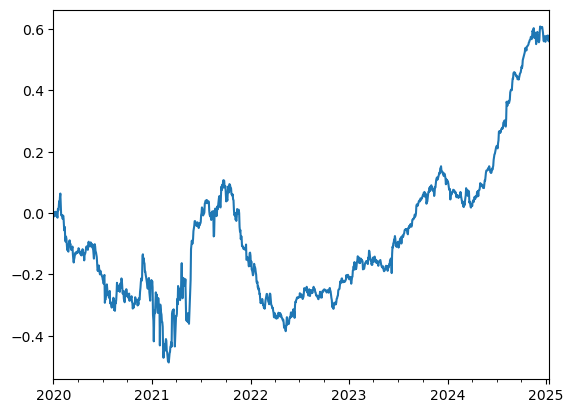

In [19]:
a,s,d,f = to_sharpe(ma(-rank_weighting(layer1_binance_ret, lookback = 4), lookback=1),layer1_binance_ret, th = 36, plot = True, return_ret=False)

In [16]:
a.cumsum().plot()   

AttributeError: 'numpy.ndarray' object has no attribute 'plot'